In [152]:
from torchvision import *
import torchvision as vision
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [153]:
model = models.vit_b_16(weights='IMAGENET1K_V1')
# model = torch.nn.Sequential(*(list(model.children())[:-1]))
df = pd.read_csv('../datasets/processed/pokemon.csv')
chosen = [20, 100]
df = df.query('dex  in @chosen')

In [154]:

# add layers to model, to complete decoder part of autoencoder
model = torch.nn.Sequential(model, torch.nn.Linear(1000, 64))
model = torch.nn.Sequential(model, torch.nn.ReLU())
model = torch.nn.Sequential(model, torch.nn.Linear(64, 128))
model = torch.nn.Sequential(model, torch.nn.ReLU())
model = torch.nn.Sequential(model, torch.nn.Linear(128, 128))
model = torch.nn.Sequential(model, torch.nn.ReLU())
model = torch.nn.Sequential(model, torch.nn.Linear(128, 128))
model = torch.nn.Sequential(model, torch.nn.ReLU())
model = torch.nn.Sequential(model, torch.nn.Linear(128, 150528))
model = torch.nn.Sequential(model, torch.nn.Sigmoid())

# use convolutional layers to complete decoder part of autoencoder
# model = torch.nn.Sequential(model, torch.nn.Conv2d(1, 64, 3, padding=1))
# model = torch.nn.Sequential(model, torch.nn.ReLU())
# model = torch.nn.Sequential(model, torch.nn.Conv2d(64, 128, 3, padding=1))
# model = torch.nn.Sequential(model, torch.nn.ReLU())
# model = torch.nn.Sequential(model, torch.nn.Conv2d(128, 256, 3, padding=1))
# model = torch.nn.Sequential(model, torch.nn.ReLU())
# model = torch.nn.Sequential(model, torch.nn.Conv2d(256, 150528, 3, padding=1))
# model = torch.nn.Sequential(model, torch.nn.Sigmoid())

In [155]:
# finetune model on pokemon dataset
epochs = 500
learning_rate = 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

In [156]:
for epoch in range(epochs):
    for i in df.index:
        img = Image.open(df['image'][i])
        img = img.convert('RGB')
        img = vision.transforms.Resize((224, 224))(img)
        img = vision.transforms.ToTensor()(img)
        img = img.unsqueeze(0)
        img = img.flatten()
        image = Image.open(df['image'][i])
        image = image.convert('RGB')
        image = vision.transforms.Resize((224, 224))(image)
        image = vision.transforms.ToTensor()(image)
        image = image.unsqueeze(0)
        output = model(image)
        loss = criterion(input= output, target= img)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print(f'Epoch: {epoch}, Loss: {loss}')

# save model
torch.save(model, 'pokemon_autoencoder.pth')

/Users/christianrasmussen/opt/miniconda3/envs/ml_project/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([150528])) that is different to the input size (torch.Size([1, 150528])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, Loss: 0.15969909727573395
Epoch: 0, Loss: 0.12557700276374817
Epoch: 1, Loss: 0.15967541933059692
Epoch: 1, Loss: 0.1255592405796051
Epoch: 2, Loss: 0.15966105461120605
Epoch: 2, Loss: 0.12555022537708282
Epoch: 3, Loss: 0.1596493124961853
Epoch: 3, Loss: 0.12554235756397247
Epoch: 4, Loss: 0.15963909029960632
Epoch: 4, Loss: 0.1255340874195099
Epoch: 5, Loss: 0.15962868928909302
Epoch: 5, Loss: 0.12552548944950104
Epoch: 6, Loss: 0.15961797535419464
Epoch: 6, Loss: 0.12551675736904144
Epoch: 7, Loss: 0.15960706770420074
Epoch: 7, Loss: 0.12550857663154602
Epoch: 8, Loss: 0.1595960408449173
Epoch: 8, Loss: 0.12550048530101776
Epoch: 9, Loss: 0.15958429872989655
Epoch: 9, Loss: 0.12549284100532532
Epoch: 10, Loss: 0.15957222878932953
Epoch: 10, Loss: 0.1254851371049881
Epoch: 11, Loss: 0.15956060588359833
Epoch: 11, Loss: 0.1254771202802658
Epoch: 12, Loss: 0.15954825282096863
Epoch: 12, Loss: 0.12546893954277039
Epoch: 13, Loss: 0.15953578054904938
Epoch: 13, Loss: 0.12546077

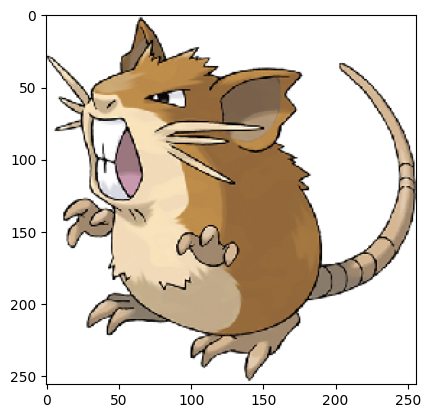

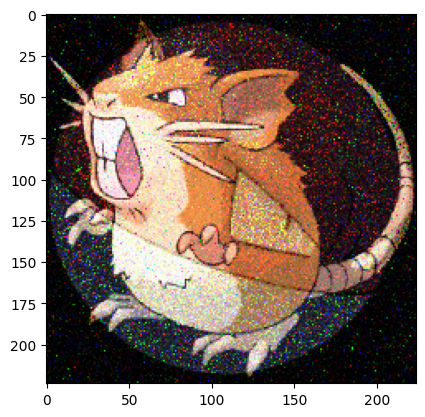

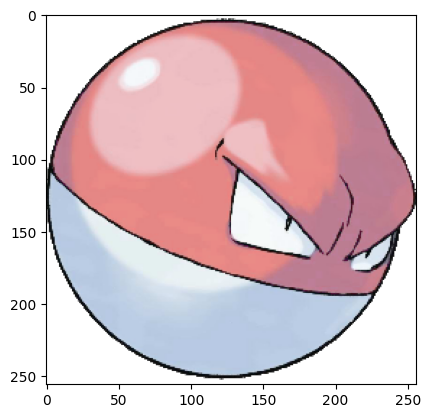

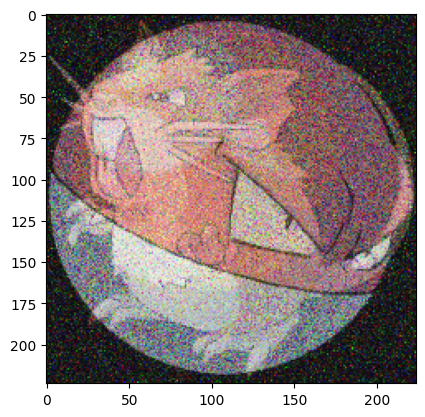

In [157]:
# df = pd.read_csv('../datasets/processed/pokemon.csv')
outputs = []
# show 5 reconstructed images
for i in df.index:
    img = Image.open(df['image'][i])
    image = Image.open(df['image'][i])
    image = image.convert('RGB')
    image = vision.transforms.Resize((224, 224))(image)
    image = vision.transforms.ToTensor()(image)
    image = image.unsqueeze(0)
    output = model(image)
    output = output.view(3, 224, 224)
    output = vision.transforms.ToPILImage()(output)
    outputs.append(output)
    plt.figure(i+10)
    plt.imshow(img)
    plt.show()
    plt.figure(i+20)
    plt.imshow(output)
    plt.show()